In [32]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt

In [33]:
class DeepfakeClassifier(nn.Module):
    def __init__(self, type='efficientnet-b0', decision_layer = "fc"):
        super(DeepfakeClassifier, self).__init__()
        self.model = EfficientNet.from_pretrained(type)
        self.fc = nn.Linear(self.model._fc.in_features, 1)
        self.model._fc = self.fc
    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [48]:
def setup_data(input_size = (224, 224), data_dir = 'data'):

    transform = transforms.Compose([  
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(data_dir, transform=transform)

    print("Dataset classes", dataset.classes)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    print("Train size: ", train_size)
    print("Validation size: ", val_size)
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    print("Class to index mapping: ", dataset.class_to_idx)

    return train_loader, val_loader, transform, dataset

train_loader, val_loader, transform, dataset = setup_data()

Dataset classes ['fake', 'real']
Train size:  1600
Validation size:  400
Class to index mapping:  {'fake': 0, 'real': 1}


In [35]:
def setup_training(feature_extraction = "efficientnet-b0", decision_layer = "fc"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model = DeepfakeClassifier(feature_extraction, decision_layer).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model, criterion, optimizer, device

feature_extraction = "efficientnet-b0"
decision_layer = "fc"
model, criterion, optimizer, device = setup_training(feature_extraction, decision_layer)

cuda
Loaded pretrained weights for efficientnet-b0


In [51]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs = 20):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        
        train_loss = train_loss / len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()


            loss = criterion(outputs, labels)
            val_loss += loss.item()

            prediction = (outputs > 0.5).float()
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))
        print('Validation Accuracy: {:.6f}', correct / total)
    print('Finished Training')
    return train_loss, val_loss, correct / total

In [ ]:
train_loss, val_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

In [62]:
def save_model(feature_extraction, decision_layer, train_loss, val_loss, val_accuracy):
    model_path = "saved_models//" + feature_extraction + " " + decision_layer
    print("Saving model to: ", model_path)
    checkpoint = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'model_state_dict': model.state_dict(),
    }
    torch.save(checkpoint, model_path + ".pth")

In [ ]:
save_model(feature_extraction, decision_layer, train_loss, val_loss, val_acc)

Saving model to:  saved_models//efficientnet-b0 fc.pth


In [39]:
def verify_image_exists(image_path):
    if os.path.exists(image_path):
        print("Image Exists")
    else:
        print("Image Does not exist")
        Exception("Image Does not exist")

<h2> Example Outputs </h2>

In [49]:
def display_and_predict(image_path, model, transforms, dataset):
    verify_image_exists(image_path)
    image = Image.open(image_path)
    image = transforms(image)
    display_image = image.permute(1, 2, 0)
    image = image.unsqueeze(0).to(device)
    plt.imshow(display_image)
    plt.axis('off')
    plt.show()
    model.eval()
    prediction = model(image)
    if dataset.class_to_idx['fake'] == 0:
        label = "Fake" if prediction.item() < 0.5 else "Real"
    else:
        label = "Fake" if prediction.item() > 0.5 else "Real"
    print("Prediction: ", label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Exists


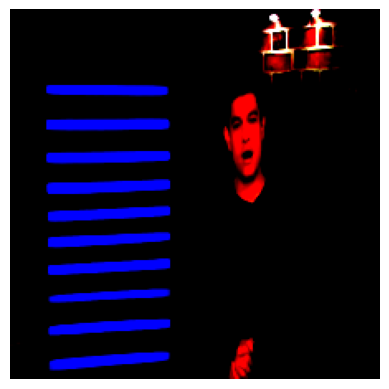

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:  Fake
Image Exists


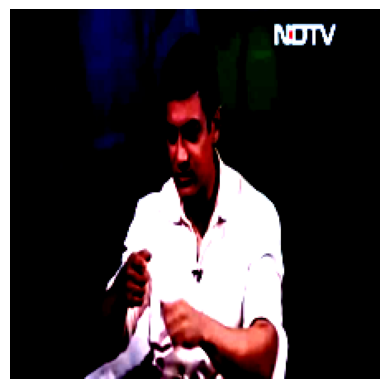

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:  Real
Image Exists


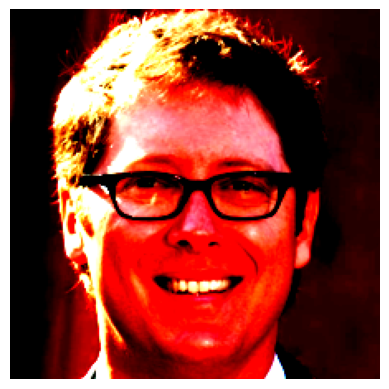

Prediction:  Real


In [50]:
sample_images = [ r"C:\Users\Raulg\Desktop\ECE661_Final_Project\661_DeepfakeProject\Classifier\data\fake\id0_id1_0000_00000.png", 
                 r"C:\Users\Raulg\Desktop\ECE661_Final_Project\661_DeepfakeProject\Classifier\data\real\Celeb-real_id0_0001_00000.png",
                 r"C:\Users\Raulg\Desktop\ECE661_Final_Project\661_DeepfakeProject\stargan-v2-master\data\celeba_hq\celeba_hq\train\male\000152.jpg"]
    
for image_path in sample_images:
    display_and_predict(image_path, model, transform, dataset)

<h2> Multiple Model Training </h2>

In [67]:
# Inputs sizes all dervied from the efficientNet-pytorch library, each model has a different input size
model_configs = {
    "b0" : {
        "feature_extraction": "efficientnet-b0",
        "decision_layer": "fc",
        "input_size": (224, 224),
        "data_dir": "data"
    },
    "b1" : {
        "feature_extraction": "efficientnet-b1",
        "decision_layer": "fc",
        "input_size": (240, 240),
        "data_dir": "data"
    },
    "b2" : {
        "feature_extraction": "efficientnet-b2",
        "decision_layer": "fc",
        "input_size": (260, 260),
        "data_dir": "data"
    },
    "b3" : {
        "feature_extraction": "efficientnet-b3",
        "decision_layer": "fc",
        "input_size": (300, 300),
        "data_dir": "data"
    },
}


for config, dict in model_configs.items():
    if os.path.exists("saved_models//" + dict["feature_extraction"] + " " + dict["decision_layer"] + ".pth"):
        print("Model already exists")
        continue
    else:
        print("Model doesn't already exist, training model")
    train_loader, val_loader, transform, dataset = setup_data(dict["input_size"], dict["data_dir"])
    model, criterion, optimizer, device = setup_training(dict["feature_extraction"], dict["decision_layer"])
    train_loss, val_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)
    save_model(dict["feature_extraction"], dict["decision_layer"], train_loss, val_loss, val_acc)

Model doesn't already exist, training model
Dataset classes ['fake', 'real']
Train size:  1600
Validation size:  400
Class to index mapping:  {'fake': 0, 'real': 1}
cuda
Loaded pretrained weights for efficientnet-b0
Epoch: 0 	Training Loss: 0.019770 	Validation Loss: 0.021270
Validation Accuracy: {:.6f} 0.575
Epoch: 1 	Training Loss: 0.013628 	Validation Loss: 0.018097
Validation Accuracy: {:.6f} 0.6725
Epoch: 2 	Training Loss: 0.008174 	Validation Loss: 0.016872
Validation Accuracy: {:.6f} 0.755
Epoch: 3 	Training Loss: 0.005130 	Validation Loss: 0.014740
Validation Accuracy: {:.6f} 0.7875
Epoch: 4 	Training Loss: 0.003649 	Validation Loss: 0.010623
Validation Accuracy: {:.6f} 0.8675
Epoch: 5 	Training Loss: 0.002893 	Validation Loss: 0.006241
Validation Accuracy: {:.6f} 0.9075
Epoch: 6 	Training Loss: 0.002261 	Validation Loss: 0.007207
Validation Accuracy: {:.6f} 0.9275
Epoch: 7 	Training Loss: 0.001761 	Validation Loss: 0.004462
Validation Accuracy: {:.6f} 0.93
Epoch: 8 	Training L

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to C:\Users\Raulg/.cache\torch\hub\checkpoints\efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:01<00:00, 35.4MB/s]


Loaded pretrained weights for efficientnet-b3
Epoch: 0 	Training Loss: 0.018871 	Validation Loss: 0.020324
Validation Accuracy: {:.6f} 0.6025
Epoch: 1 	Training Loss: 0.010431 	Validation Loss: 0.019830
Validation Accuracy: {:.6f} 0.72
Epoch: 2 	Training Loss: 0.004819 	Validation Loss: 0.008101
Validation Accuracy: {:.6f} 0.915
Epoch: 3 	Training Loss: 0.003300 	Validation Loss: 0.007565
Validation Accuracy: {:.6f} 0.93
Epoch: 4 	Training Loss: 0.002495 	Validation Loss: 0.006407
Validation Accuracy: {:.6f} 0.9275
Epoch: 5 	Training Loss: 0.001705 	Validation Loss: 0.004790
Validation Accuracy: {:.6f} 0.9375
Epoch: 6 	Training Loss: 0.001423 	Validation Loss: 0.004765
Validation Accuracy: {:.6f} 0.9475
Epoch: 7 	Training Loss: 0.000987 	Validation Loss: 0.007788
Validation Accuracy: {:.6f} 0.9225
Epoch: 8 	Training Loss: 0.000704 	Validation Loss: 0.006809
Validation Accuracy: {:.6f} 0.9375
Epoch: 9 	Training Loss: 0.000722 	Validation Loss: 0.006037
Validation Accuracy: {:.6f} 0.945


In [66]:
model = DeepfakeClassifier("efficientnet-b1", "fc")
saved = torch.load("saved_models//efficientnet-b1 fc.pth")
model.load_state_dict(saved['model_state_dict'])

print("Train loss:", saved['train_loss'])
print("Validation loss:", saved['val_loss'])
print("Validation accuracy:", saved['val_accuracy'])

Loaded pretrained weights for efficientnet-b1
Train loss: 0.000559321596083464
Validation loss: 0.0023176088416948914
Validation accuracy: 0.975


C:\Users\Raulg\AppData\Local\Temp\ipykernel_16788\2708658846.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load("saved_models//efficientnet-b1 fc.pth")
